Clasificación utilizando LightGBM (LGBM) (Core)


Objetivo

Implementar un pipeline completo de machine learning para un problema de clasificación utilizando LightGBM (LGBM). Se hará especial énfasis en el Análisis Exploratorio de Datos (EDA), preprocesamiento, entrenamiento del modelo y optimización de hiperparámetros.

Dataset: Loan Prediction Dataset

Descripción del Dataset: El dataset de predicción de préstamos contiene información sobre solicitantes de préstamos, como sus ingresos, historial crediticio y otras características personales. El objetivo es predecir si un solicitante será aprobado para un préstamo basándose en estos factores.

In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Parte 1: Carga y Exploración Inicial de Datos

## Carga del Dataset:
Cargar el dataset desde Kaggle.

In [98]:
# cargar el dataset
data = pd.read_csv('../data/trainboost.csv')

## Exploración Inicial:
* Revisar la estructura del dataset.
* Describir las variables y su distribución.
* Identificar y documentar valores faltantes y outliers.

In [99]:
print(data.shape)
print(data.columns)
data.info()
data.head(5)

(614, 13)
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Are

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [100]:
data.describe()


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [101]:
data = data.drop(columns=['Loan_ID'])

In [102]:
out_applicant = data[data['ApplicantIncome'] > 20000][['ApplicantIncome', 'LoanAmount']]
print(out_applicant)

     ApplicantIncome  LoanAmount
126            23803       370.0
130            20166       650.0
155            39999       600.0
171            51763       700.0
183            33846       260.0
185            39147       120.0
284            20667         NaN
308            20233       480.0
333            63337       490.0
409            81000       360.0
443            37719       152.0
506            20833       480.0


In [103]:
data = data[data['ApplicantIncome'] < 20000] #no son outliers pero sesgan demasiado los datos
data = data[(data['CoapplicantIncome'] <= 20000)] 

In [104]:
data.isnull().sum()

Gender               11
Married               3
Dependents           15
Education             0
Self_Employed        30
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           21
Loan_Amount_Term     14
Credit_History       47
Property_Area         0
Loan_Status           0
dtype: int64

In [105]:
# eliminamos filas con valores nulos
data = data.dropna()
print(data.isnull().sum())

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [106]:
def convert_object_to_category(data):
    for col in data.select_dtypes(include=['object']).columns:
        data[col] = data[col].astype('category')
    return data

# Usando la función en tu dataset
data = convert_object_to_category(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473 entries, 1 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Gender             473 non-null    category
 1   Married            473 non-null    category
 2   Dependents         473 non-null    category
 3   Education          473 non-null    category
 4   Self_Employed      473 non-null    category
 5   ApplicantIncome    473 non-null    int64   
 6   CoapplicantIncome  473 non-null    float64 
 7   LoanAmount         473 non-null    float64 
 8   Loan_Amount_Term   473 non-null    float64 
 9   Credit_History     473 non-null    float64 
 10  Property_Area      473 non-null    category
 11  Loan_Status        473 non-null    category
dtypes: category(7), float64(4), int64(1)
memory usage: 26.3 KB


In [107]:
def print_unique_values(data):
    # Filtrar las columnas de tipo 'category'
    category_columns = data.select_dtypes(include=['category']).columns
    
    # Recorrer las columnas y mostrar sus valores únicos
    for col in category_columns:
        print(f"Columna: {col}")
        print(data[col].cat.categories.tolist())  # Mostrar los valores únicos como lista
        print("-" * 40)

# Llama a la función con tu dataset
print_unique_values(data)

Columna: Gender
['Female', 'Male']
----------------------------------------
Columna: Married
['No', 'Yes']
----------------------------------------
Columna: Dependents
['0', '1', '2', '3+']
----------------------------------------
Columna: Education
['Graduate', 'Not Graduate']
----------------------------------------
Columna: Self_Employed
['No', 'Yes']
----------------------------------------
Columna: Property_Area
['Rural', 'Semiurban', 'Urban']
----------------------------------------
Columna: Loan_Status
['N', 'Y']
----------------------------------------


In [108]:
data['Credit_History'].unique()

array([1., 0.])

In [109]:
# Convertir la columna 'Credit_History' a booleana
data['Credit_History'] = data['Credit_History'].astype(bool)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473 entries, 1 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Gender             473 non-null    category
 1   Married            473 non-null    category
 2   Dependents         473 non-null    category
 3   Education          473 non-null    category
 4   Self_Employed      473 non-null    category
 5   ApplicantIncome    473 non-null    int64   
 6   CoapplicantIncome  473 non-null    float64 
 7   LoanAmount         473 non-null    float64 
 8   Loan_Amount_Term   473 non-null    float64 
 9   Credit_History     473 non-null    bool    
 10  Property_Area      473 non-null    category
 11  Loan_Status        473 non-null    category
dtypes: bool(1), category(7), float64(3), int64(1)
memory usage: 23.1 KB


# Parte 2: Análisis Exploratorio de Datos (EDA)

## Análisis Estadístico Descriptivo y Visualizaciones
* Calcular estadísticas descriptivas básicas (media, mediana, desviación estándar, etc.).
* Analizar la distribución de las variables categóricas.

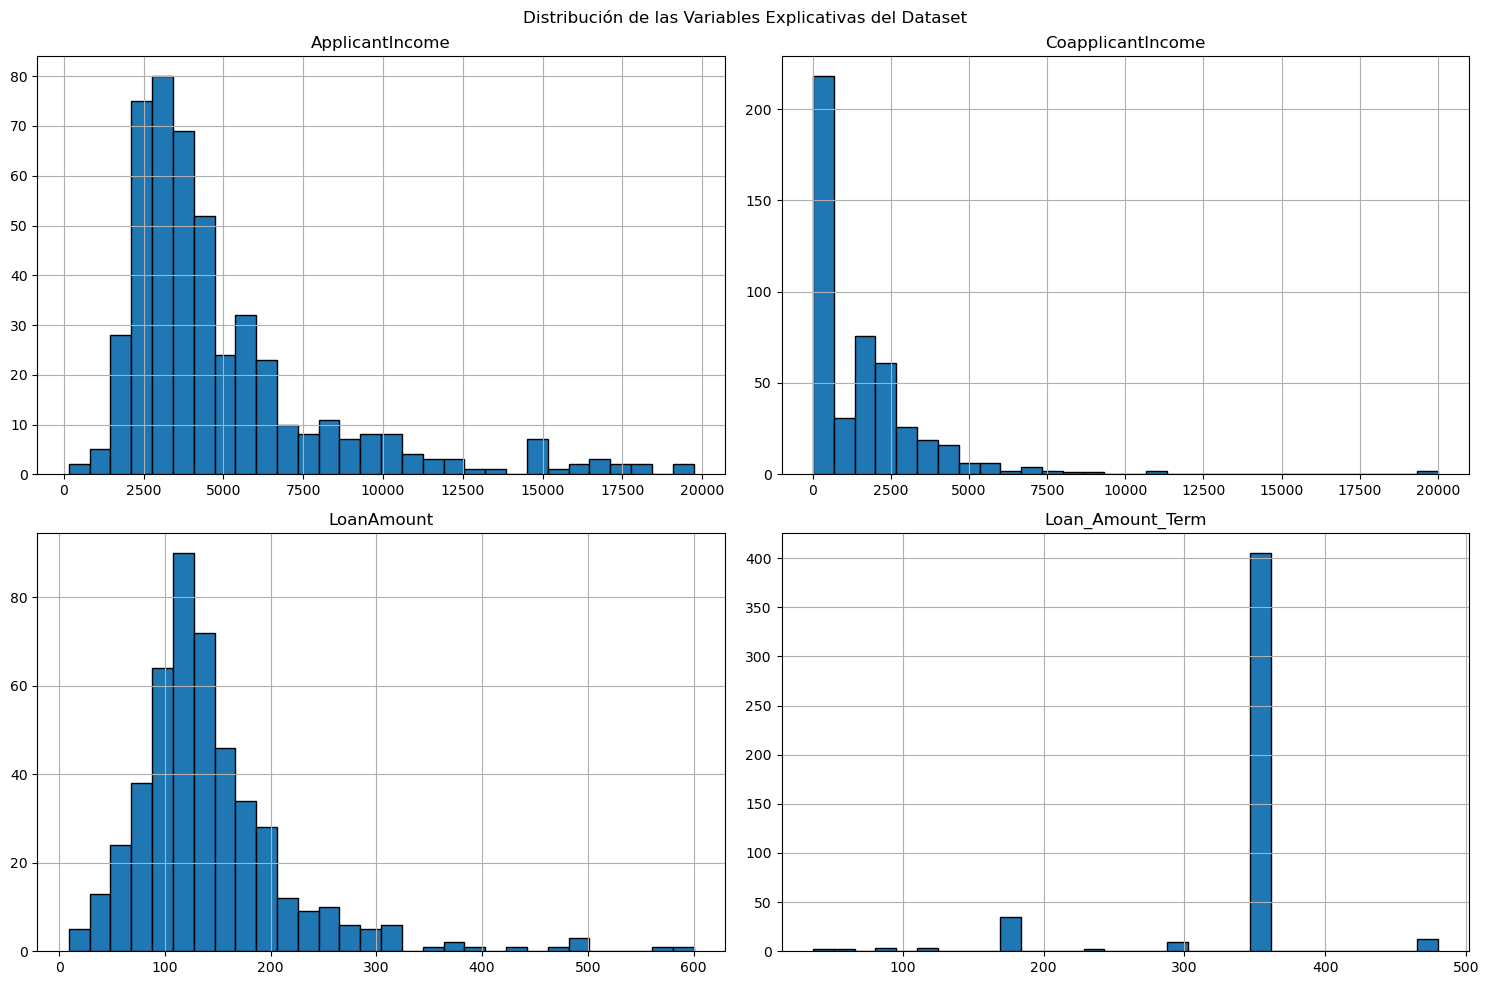

In [110]:
# Crear histogramas para cada característica
data.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle('Distribución de las Variables Explicativas del Dataset')
plt.tight_layout()
plt.show()


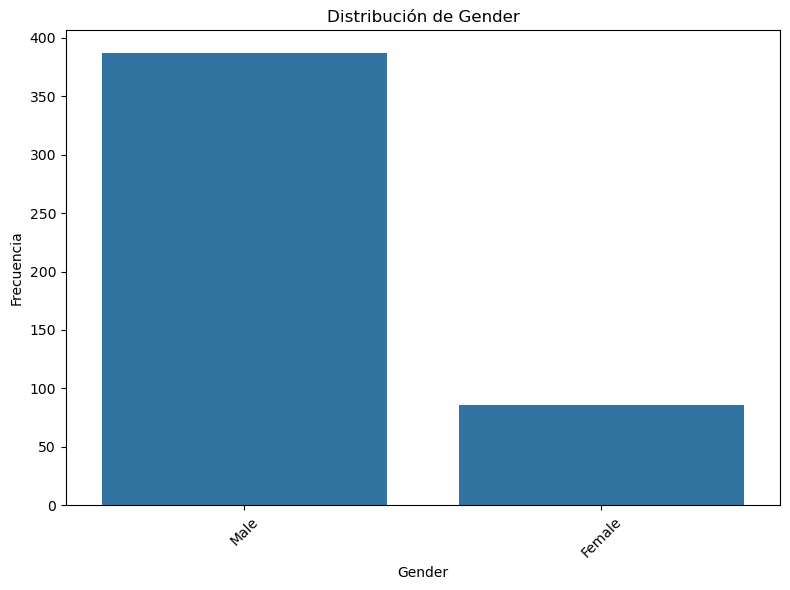

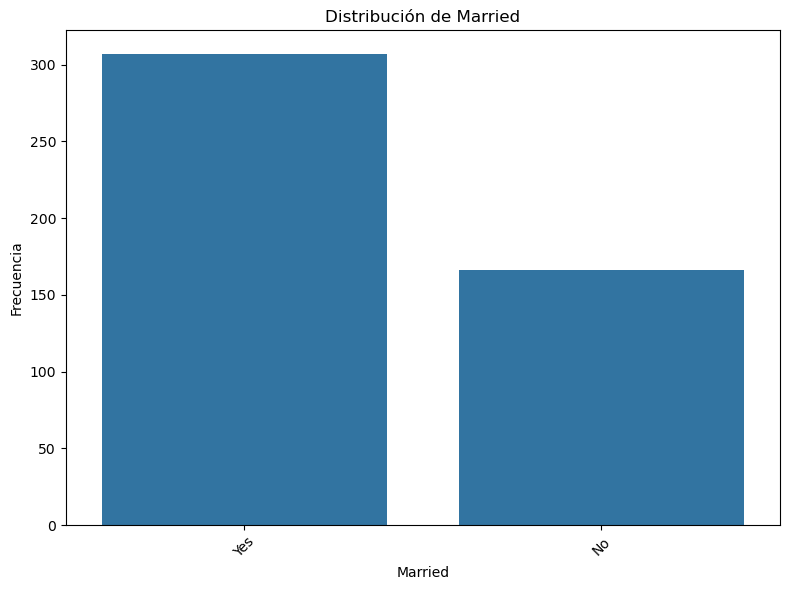

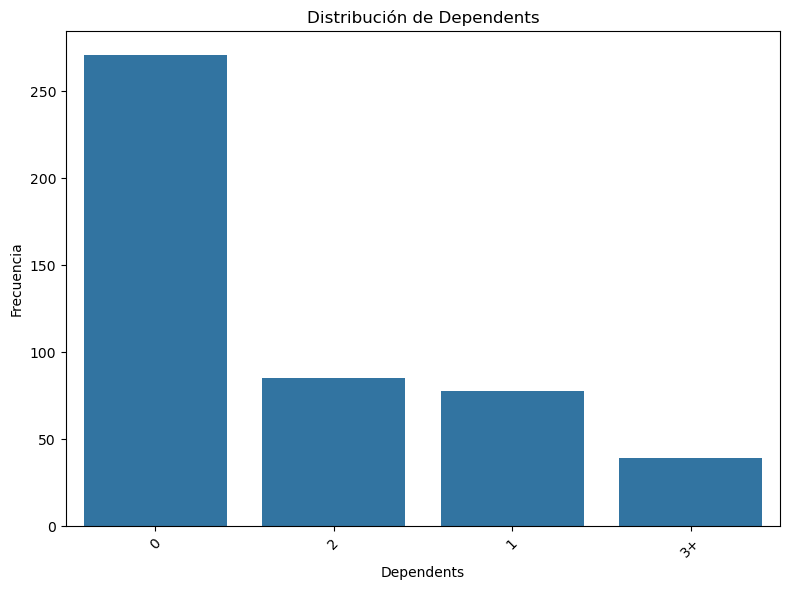

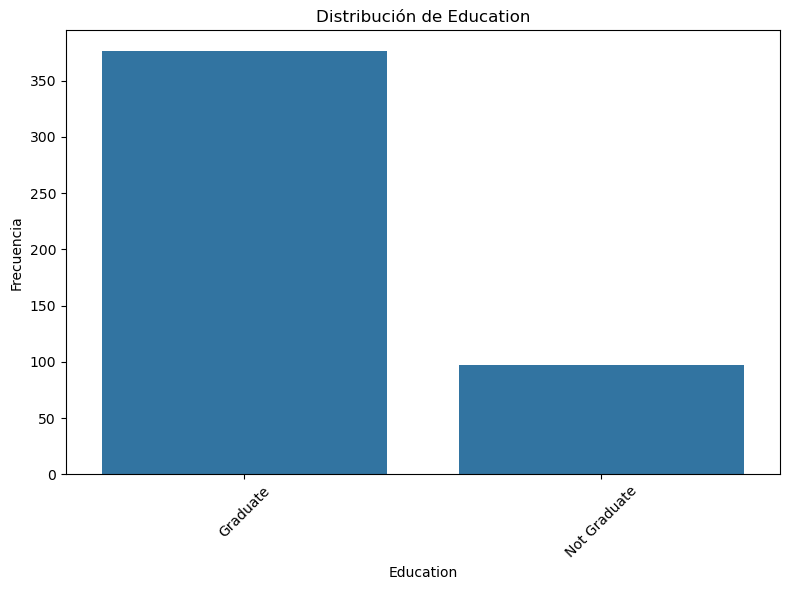

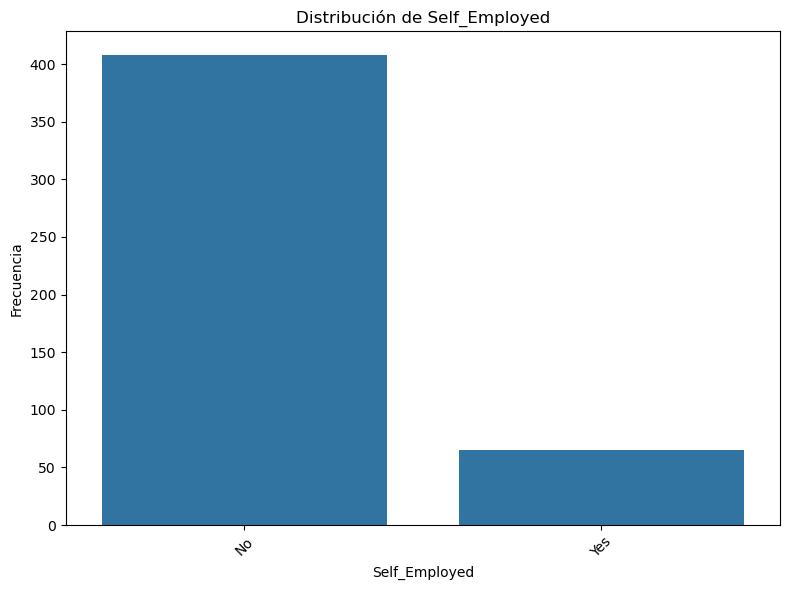

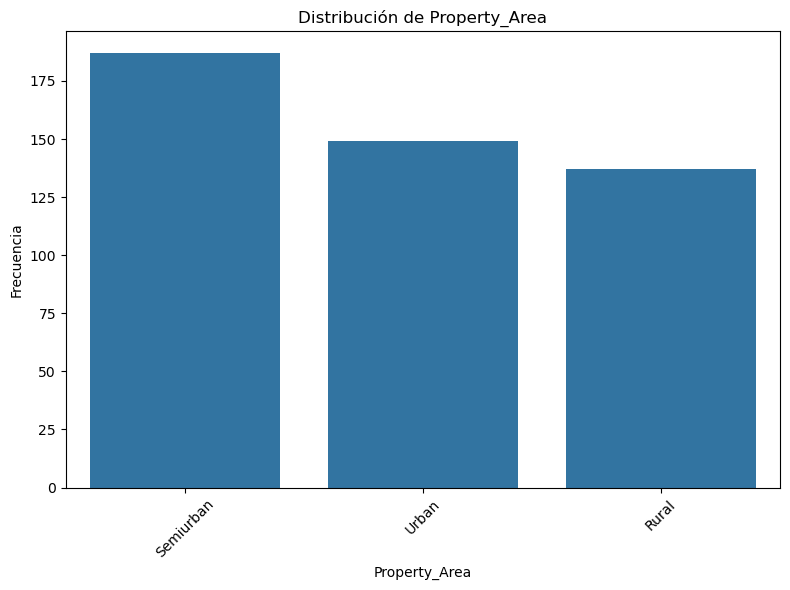

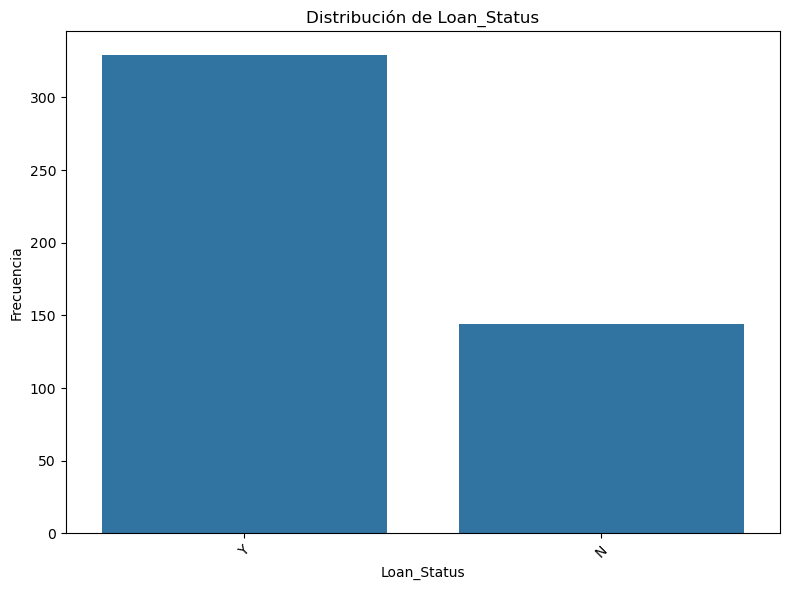

In [111]:
def plot_categorical_columns(data):
    # Seleccionar columnas categóricas
    categorical_columns = data.select_dtypes(include=['category', 'object']).columns
    
    # Crear gráficos para cada columna categórica
    for col in categorical_columns:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=data, x=col, order=data[col].value_counts().index)
        plt.title(f"Distribución de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.xticks(rotation=45)  # Rotar etiquetas si son largas
        plt.tight_layout()
        plt.show()

# Llamar a la función con tu dataset
plot_categorical_columns(data)

# Parte 3: Preprocesamiento de Datos

## Transformación de Columnas:
* Codificar variables categóricas utilizando One-Hot Encoding.
* Escalar características numéricas utilizando StandardScaler.

In [ ]:
# Seleccionar columnas 
X = data[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 
          'ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']] 
y = data['Loan_Status']

# Definir columnas categóricas y numéricas
numerical_columns = ['Loan_Amount_Term', 'LoanAmount', 'ApplicantIncome']
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

# Definir transformaciones específicas para cada tipo de dato
preprocessor = ColumnTransformer(
    transformers=[    
        ('num', StandardScaler(), numerical_columns),  # Escalado numérico
        ('cat', OneHotEncoder(), categorical_columns)  # Codificación categórica
    ]
)

NameError: name 'data' is not defined

# Parte 4: Implementación de LightGBM (LGBM)

## Entrenamiento del Modelo:
* Entrenar un modelo de LGBM con hiperparámetros básicos.
* Evaluar el modelo utilizando métricas de rendimiento como la exactitud, precisión, recall, F1-Score y ROC-AUC.

In [137]:

model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Primero el preprocesamiento
    ('lgbm', LGBMClassifier(scale_pos_weight=10))  # Luego el modelo LGBM
])


# Paso 6: Entrenar el modelo
model.fit(X_train, y_train)

# Paso 7: Hacer predicciones
y_pred = model.predict(X_test)

# Paso 8: Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud (Accuracy): {accuracy}")

# Imprimir clasificación detallada
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=['Y', 'N'])
print("\nMatriz de confusión:\n", cm)

[LightGBM] [Info] Number of positive: 229, number of negative: 102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 331, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691843 -> initscore=0.808749
[LightGBM] [Info] Start training from score 0.808749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [138]:
# Definir los hiperparámetros a optimizar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles
    'learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    'max_depth': [3, 5, 7, 10],  # Profundidad de los árboles
    'min_child_samples': [20, 50],  # Mínimo de muestras por hoja
    'subsample': [0.7, 0.8, 1.0],  # Submuestra de datos por árbol
    'colsample_bytree': [0.7, 0.8, 1.0]  # Submuestra de columnas por árbol
}

# Crear el modelo base
model = LGBMClassifier()

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=3,  # Validación cruzada con 3 divisiones
                           n_jobs=-1,  # Usar todos los núcleos del procesador
                           verbose=1,  # Mostrar progreso durante el ajuste
                           scoring='accuracy')  # Métrica de evaluación

# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados: ", grid_search.best_params_)

# Hacer predicciones con el mejor modelo encontrado
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluar el modelo
print(f"Exactitud: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[LightGBM] [Info] Number of positive: 229, number of negative: 102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 331, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.691843 -> initscore=0.808749
[LightGBM] [Info] Start training from score 0.808749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

## Evaluación del Modelo Optimizado:
Evaluar el rendimiento del modelo optimizado y compararlo con el modelo inicial.

* Reporte de clasificación:
* Exactitud (Accuracy): 0.6971830985915493

               precision    recall  f1-score   support

           N       0.33      0.02      0.04        42
           Y       0.71      0.98      0.82       100

    accuracy                           0.70       142
   macro avg       0.52      0.50      0.43       142
weighted avg       0.60      0.70      0.59       142

* Reporte de clasificación mejorado con gridsearchCV
* Exactitud: 0.8098591549295775

              precision    recall  f1-score   support

           N       0.89      0.40      0.56        42
           Y       0.80      0.98      0.88       100

    accuracy                           0.81       142
   macro avg       0.85      0.69      0.72       142
weighted avg       0.83      0.81      0.78       142

